
## 1.3. ROC-AUC
В этом ноутбуке мы научимся строить ROC-кривую на примере задачи предсказания отклика на маркетинговую кампанию

## Постановка задачи
Для нового продукта банка необходимо определить круг клиентов, которым будет совершён телефонный звонок с предложением продукта. Известно, что один звонок независимо от результата стоит 10 рублей, а каждый успешный звонок приносит банку 100 рублей. Цель -- максимизировать прибыль банка. 

Мы имеем задачу классификации клиентов на два класса. Для каждого клиента будем предсказывать вероятность отклика на кампанию, а затем выберем пороговую вероятность обзвона. Предсказывать вероятность предлагается с помощью логистической регрессии.

## Сбор данных
В вашем распоряжении есть выборка из предыдущих звонков, для каждого из которых имеется вектор признаков (характеристики клиента и продукта), а также результат звонка. Загрузим данные с помощью библиотеки Pandas. Создадим объект ``data`` класса ``pandas.DataFrame``.

Описание данных: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
data = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')
# Если строчка не выполняется, ноутбук нужно сохранить на 
# компьютере и данные положить в ту же папку



Взглянем на выборку, соберём предварительную информацию о ней, изучим признаки с помощью функций ``head``, ``info``, ``describe`` библиотеки Pandas.

In [17]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [19]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Выделение целевой переменной

Выделим целевое значение в переменную ``y``.

In [20]:
data.loc[data['y'] == 'yes', 'y'] = 1
data.loc[data['y'] == 'no', 'y'] = 0

data['y'] = data['y'].astype(int)

data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [21]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

Видим, что классы очень несбалансированы. 

## Предварительный анализ признаков
В датасете есть признак ``duration``, обозначающий длительность совершённого звонка. Это значение неизвестно до совершения звонка, поэтому не может быть использовано для предсказания. Удалим эту переменную из рассмотрения. Сделаем это с помощью метода ``drop`` класса ``pandas.DataFrame``.

In [22]:
data = data.drop(columns=['duration'])

В датасете многие признаки являются категориальными. Мы ограничимся их one-hot кодированием. 

## One-hot кодирование
One-hot кодирование категориального признака ``feature``, принимающего $k$ значений ``1``, ``2``, ``3``, $\ldots$, ``t``, заключается в создании $t$ новых бинарных признаков ``"feature == 1"``, ``"feature == 2"``, $\ldots$, ``"feature == t"``, определяющихся по формуле

$$\text{"feature == i"} = 
\begin{cases}
1,& feature = i\\
0,& feature \neq i
\end{cases}.$$

One-hot encoding с помощью Pandas можно выполнить с помощью функции ``get_dummies``. 

In [23]:
# Разделим признаки на числовые и категориальные с помощью функции ``select_dtypes``

data_categorical = data.select_dtypes(include=['object'])
data_numeric = data.select_dtypes(exclude=['object'])

# one-hot кодирование
data_one_hot = pd.get_dummies(data_categorical)

In [24]:
# формируем общую матрицу объекты-признаки и выделяем целевую переменную

X = pd.concat([data_numeric, data_one_hot], axis='columns').drop(columns=['y'])
y = data['y']

In [25]:
X.shape

(41188, 62)

## Составление плана обучения и тестирования, train и test

Прежде чем производить обработку признаков, необходимо составить план обучения и тестирования. Чтобы смоделировать "реальную" производственную ситуацию и избежать переобучения, необходимо разделить данные на train и test. Выборка test **будет недоступна** на стадии обработки признаков и обучения. Строго говоря, выделение категориальных признаков также необхоимо было проводить после разбиения, но для простоты мы опустим этот момент.

Разобьём данные на train и test в соотношении 70:30 с помощью функции ``train_test_split`` модуля ``sklearn.model_selection``.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Обработка числовых признаков, нормировка
Есть множество методов обработки, генерации новых признаков, отбора признаков и т.д. Многие из них реализованы в модулях ``sklearn.preprocessing`` и ``sklearn.feature_selection``. Сейчас мы ограничимся нормировкой признаков. 

Нормировка признаков производится по формуле 
$$x \rightarrow \frac{x - a}{\sigma},$$
где $a$ -- среднее значение признака, а $\sigma$ -- среднее квадратическое отклонение признака, вычисляемое по формуле $$\sigma = \sqrt{\frac{(x_1 - a)^2 + \ldots + (x_n - a)^2}{n}}.$$


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение алгоритма

Создадим и обучим логистическую регрессию. Нужный нам класс ``LogisticRegression`` находится в модуле ``sklearn.linear_model``.
Предскажем вероятности принадлежности объектов обучающей выборки к классу 1. Используем метод модели ``predict_proba``.

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)

In [29]:
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

### Построение ROC-кривой и измерение ROC-AUC score

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

Train roc-auc: 0.7942141727910437
Test roc-auc: 0.7953648234785857


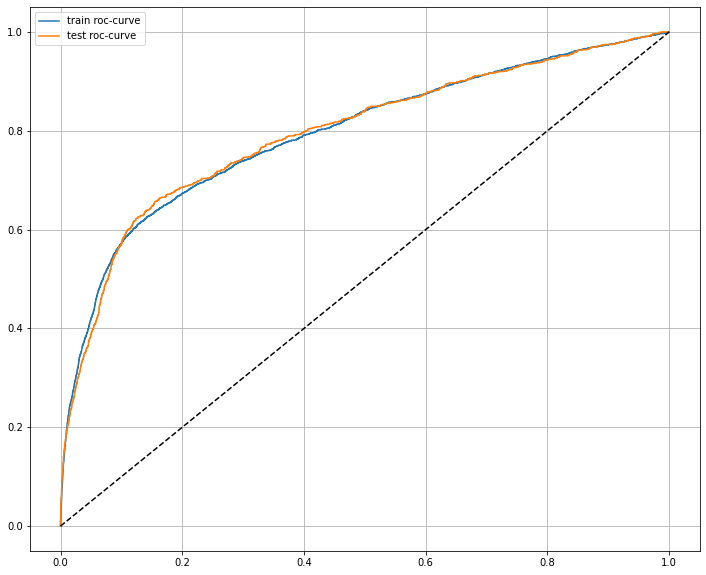

In [31]:
plt.figure(figsize=(12,10))

print(f'Train roc-auc: {roc_auc_score(y_train, y_train_proba)}')
print(f'Test roc-auc: {roc_auc_score(y_test, y_test_proba)}')


plt.plot(*roc_curve(y_train, y_train_proba)[:2], label='train roc-curve')
plt.plot(*roc_curve(y_test, y_test_proba)[:2], label='test roc-curve')

plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.grid(True)
plt.legend()
plt.show()